In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

## Markovian methods

### Monte Carlo


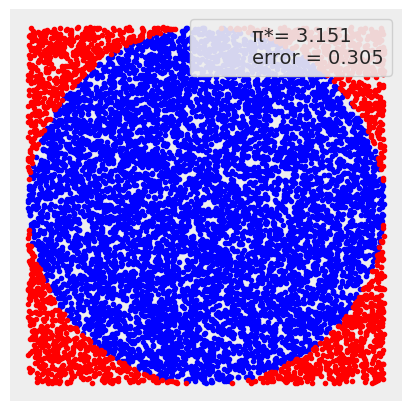

In [3]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum() * 4 / N
error = abs((pi - np.pi) / pi) * 100

outside = np.invert(inside)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x[inside], y[inside], 'b.')
ax.plot(x[outside], y[outside], 'r.')
ax.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
ax.axis('square')
ax.set(xticks=[], yticks=[])
ax.legend(loc=1, frameon=True, framealpha=0.9)
# plt.savefig('images/ch14/pi.png')

In [4]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = func.pdf(old_x)

    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x

    return trace

In [5]:
from scipy import stats

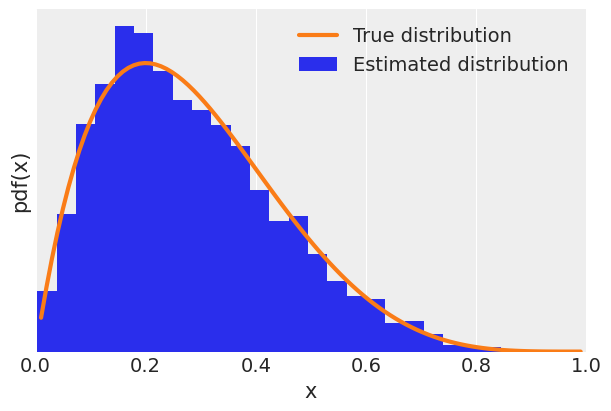

In [6]:
np.random.seed(3)
func = stats.beta(2, 5)

trace = metropolis(func=func)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x, y, 'C1-', lw=3, label='True distribution')
ax.hist(trace[trace > 0],
        bins=25,
        density=True,
        label='Estimated distribution')
ax.set(xlabel='x', ylabel='pdf(x)', yticks=[], xlim=(0, 1))
ax.legend()
# plt.savefig('images/ch14/metropolis.png')

## Diagnosing the samples

In [7]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    # trace_cm = pm.sample(2000, random_seed=7, return_inferencedata=True)
    # trace_cm.to_netcdf("data/ch14/mc_centered.nc")
    trace_cm = az.from_netcdf("../../datasets/pymc/ch14/mc_centered.nc")

In [8]:
with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)

    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + b_offset * a)
    # trace_ncm = pm.sample(2000, random_seed=7, return_inferencedata=True)
    # trace_ncm.to_netcdf("data/ch14/mc_uncentered.nc")
    trace_ncm = az.from_netcdf("../../datasets/pymc/ch14/mc_uncentered.nc")

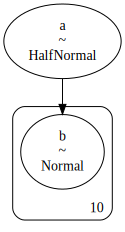

In [9]:
pm.model_to_graphviz(centered_model)

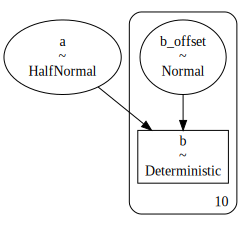

In [10]:
pm.model_to_graphviz(non_centered_model)

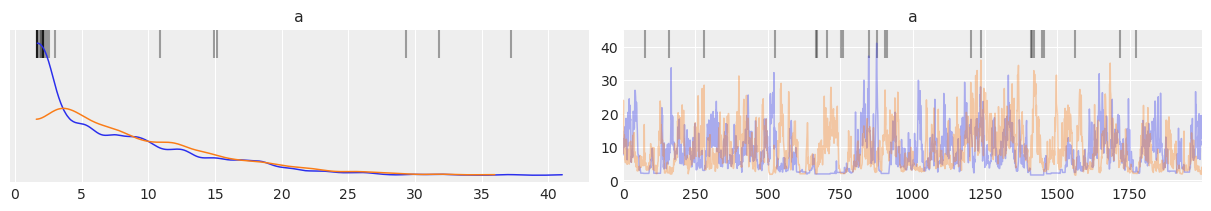

In [11]:
az.plot_trace(trace_cm, var_names=['a'], divergences='top', compact=False);
# plt.savefig('images/ch14/convergence.png')

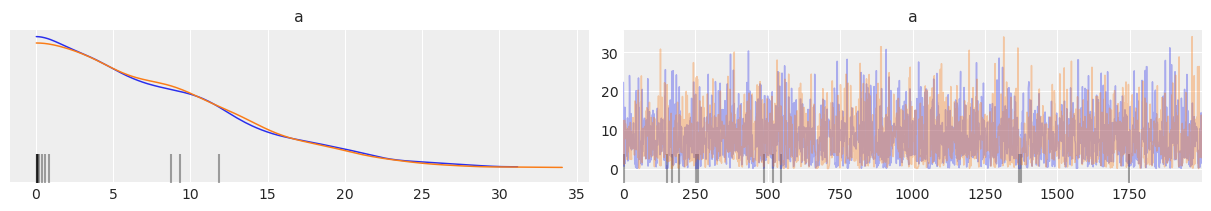

In [12]:
az.plot_trace(trace_ncm, var_names=['a'], compact=False);
# plt.savefig('images/ch14/convergence2.png')

In [13]:
az.rhat(trace_cm)['a'].values

array(1.01206445)

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

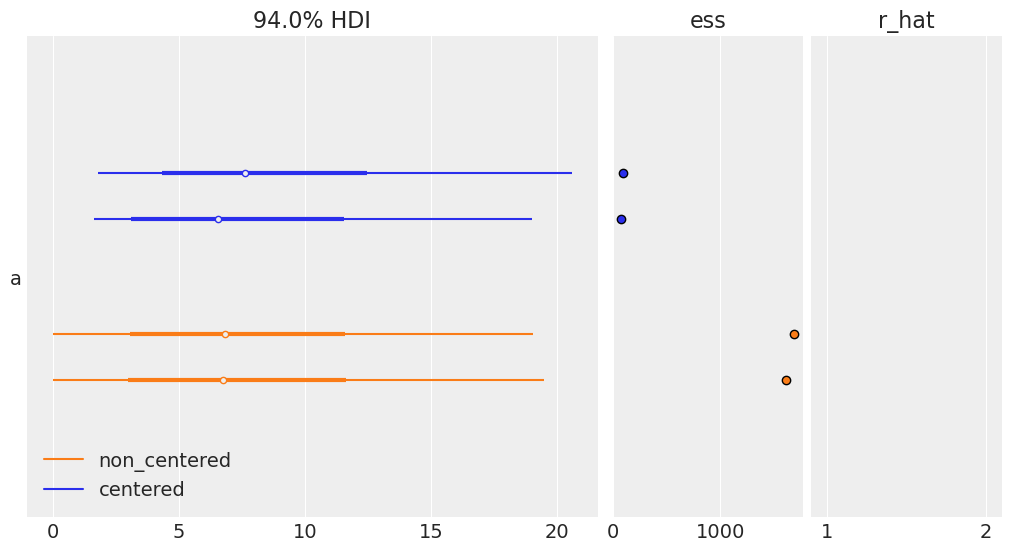

In [14]:
az.plot_forest([trace_cm, trace_ncm],
               model_names=['centered', 'non_centered'],
               var_names=['a'],
               r_hat=True,
               ess=True)
# plt.savefig('images/ch14/convergence_forest.png')

In [15]:
summaries = pd.concat([az.summary(trace_cm, var_names=['a']),
           az.summary(trace_ncm, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centered,8.701,6.132,1.560,19.752,0.484,0.343,89.0,109.0,1.01
non_centered,7.985,6.142,0.006,19.196,0.108,0.077,2145.0,1290.0,1.00


In [16]:
summaries.to_markdown()

'|              |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_bulk |   ess_tail |   r_hat |\n|:-------------|-------:|------:|---------:|----------:|------------:|----------:|-----------:|-----------:|--------:|\n| centered     |  8.701 | 6.132 |    1.56  |    19.752 |       0.484 |     0.343 |         89 |        109 |    1.01 |\n| non_centered |  7.985 | 6.142 |    0.006 |    19.196 |       0.108 |     0.077 |       2145 |       1290 |    1    |'

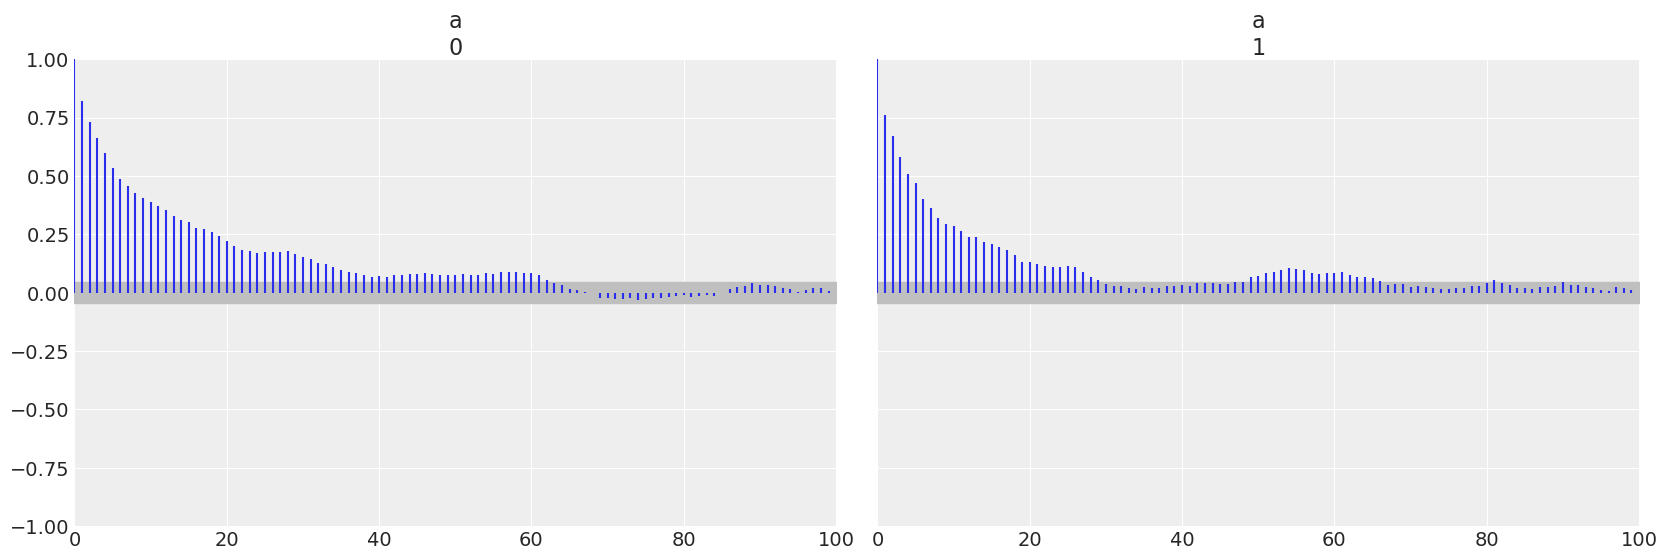

In [17]:
az.plot_autocorr(trace_cm, var_names=['a']);

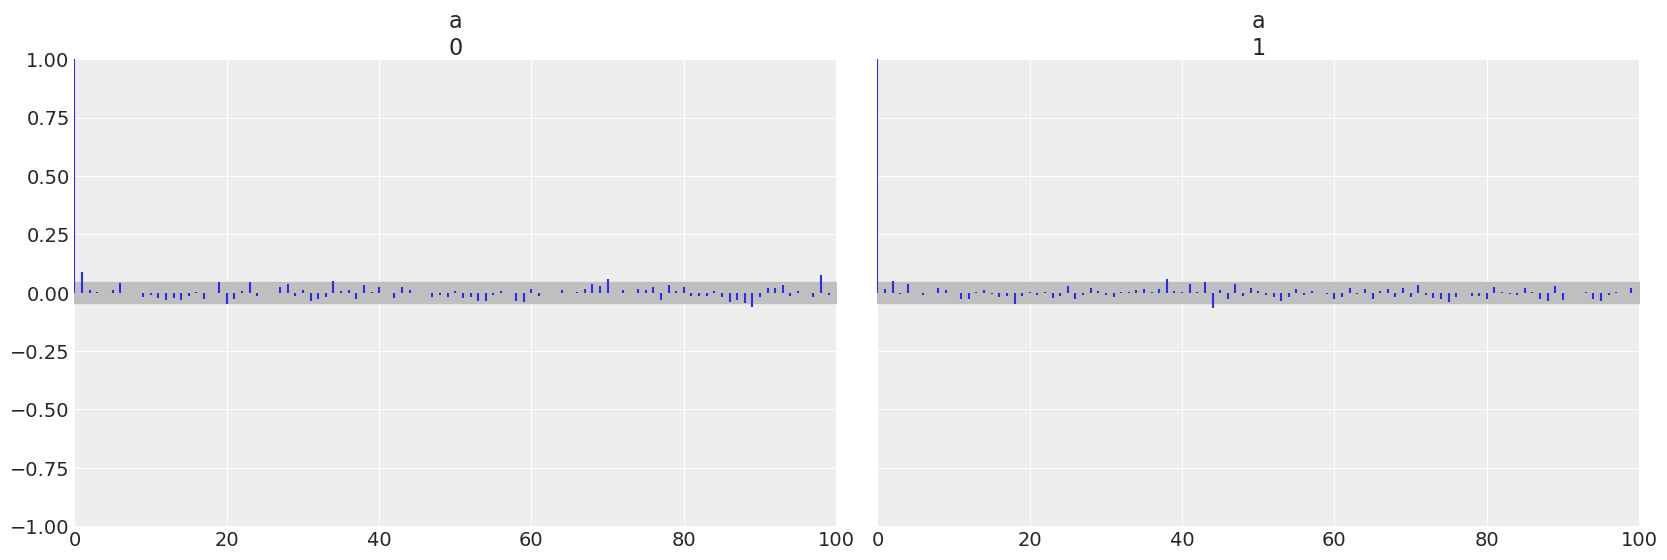

In [18]:
az.plot_autocorr(trace_ncm, var_names=['a']);

## Effective sample size

In [19]:
az.ess(trace_cm)['a'].values

array(88.71643543)

## Divergences

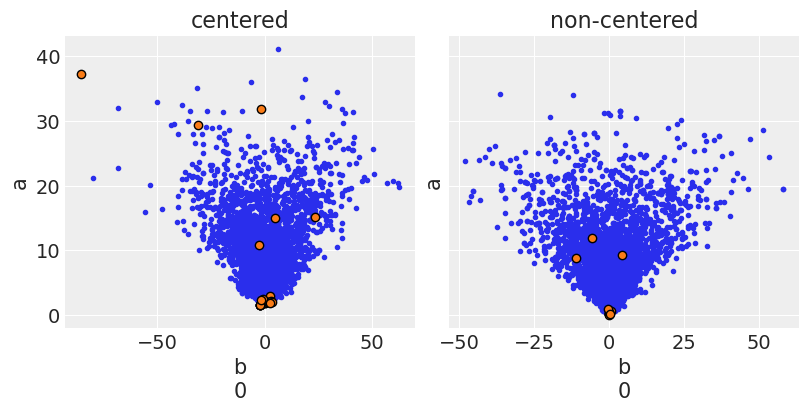

In [20]:
_, axes = plt.subplots(1,
                       2,
                       figsize=(8, 4),
                       
                       sharey=True,
                       constrained_layout=True)

ax = axes.flatten()

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr,
                 var_names=['b', 'a'],
                 coords={'b_dim_0': [0]},
                 kind='scatter',
                 divergences=True,
                 contour=False,
                 divergences_kwargs={'color': 'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

# plt.savefig('images/ch14/divergence.png')

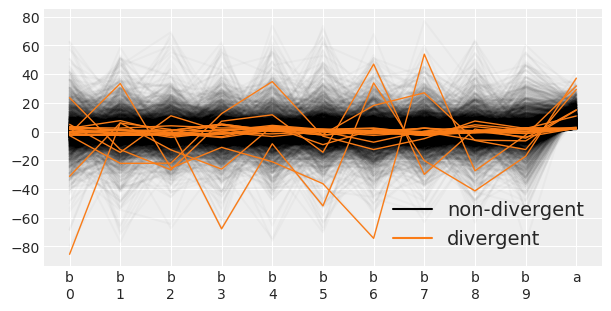

In [21]:
_, ax = plt.subplots(figsize=(6, 3))

az.plot_parallel(trace_cm, ax=ax);
# plt.savefig('images/ch14/parallel.png')